<h1>Project: ATX Wedding Planners/Organizers Analysis</h1>

**Team member:** Poonnawit Suwatanapongched, Joel Brisola, Shreyas Venkatakrishnaiah, Samridhi Sehgal, and Srishti Gupta

<h2>Scrape Reviews & Instagram Links from Knot.com</h2>

In [ ]:
#virtual environment name: uda_final_project
import time
import selenium
import webdriver_manager
import pandas as pd
import numpy as np
import re

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait

planner_link=[]

#function to scrape the link of each wedding planner's profile

Create ChromeOptions object
chrome_options = Options()

service = Service(ChromeDriverManager().install())

url_links=['https://www.theknot.com/marketplace/wedding-planners-austin-tx?sort=featured', 
           'https://www.theknot.com/marketplace/wedding-planners-austin-tx?page=2&sort=featured', 
           'https://www.theknot.com/marketplace/wedding-planners-austin-tx?page=3&sort=featured']

for url_link in url_links:

    driver = webdriver.Chrome(service=service, options=chrome_options)
    driver.get(url_link)
    container_element=driver.find_element(By.XPATH,'//*[@id="app"]/div/div[3]/div/div/div/div[6]/div[1]/div[1]/div/div')
    href_tag=container_element.find_elements(By.CLASS_NAME,"info-container--2d227")
    for element in href_tag:
        href=element.get_attribute("href")
        planner_link.append(href)
    driver.close()

planner_name_list=[]
instagram_link_list=[]

#function to scrape the instagram link for each wedding planner
def scraper(url):

    global planner_name_list, instagram_link_list
    driver = webdriver.Chrome(service=service, options=chrome_options)
    driver.get(url)
    planner_name=driver.find_element(By.TAG_NAME,"h1").text
    try:
        instagram_element=driver.find_element(By.XPATH,"//a[@title='instagram']")
        instagram_link=instagram_element.get_attribute("href")

    except:
        instagram_link=np.nan

    print(planner_name, instagram_link)
    planner_name_list.append(planner_name)
    instagram_link_list.append(instagram_link)
    driver.close()


for link in planner_link:
    scraper(link)

df=pd.DataFrame({'Planner_Name':planner_name_list,'Instagram_Link':instagram_link_list,'Planner_Link':planner_link})
df.to_csv('instagram.csv')


#function to scrape the reviews for each wedding planner
from selenium.common.exceptions import NoSuchElementException

def review_scraper(url_link):
    chrome_options = Options()
    service = Service(ChromeDriverManager().install())

    try:

        driver = webdriver.Chrome(service=service, options=chrome_options)
        driver.get(url_link)
        scroll_distance = 1000
        item_list = []

        try:
            reviews_element = driver.find_element(By.CSS_SELECTOR, ".reviews-count-text--57b11")
            reviews_text = reviews_element.text
            number_of_reviews = int(reviews_text.split()[0])
            print("Number of reviews",number_of_reviews)

        except:
            return 0,0,[]

        while True:
            # # Scroll down a bit to make sure new reviews are loaded
            driver.execute_script(f"window.scrollBy(0, {scroll_distance});")
            time.sleep(2)  # Wait for the page to load
            try:
                button_element = driver.find_element(By.XPATH, '//div[@id="navReviews"]/button')
                button_element.click()
                time.sleep(5)  # Wait for new reviews to load after clicking
            except NoSuchElementException:
                # If the button is not found, exit the loop
                break

    except Exception as e:
        print(f"An error occurred: {e}")
        driver.quit()
        pass

    finally:

        review_items = driver.find_elements(By.XPATH, '//meta[@itemprop="description"]')

        for item in review_items:
            item_list.append(item.get_attribute('content'))

        reviews_scraped=len(item_list)

        print("Reviews Scraped",reviews_scraped)
        driver.quit()

    return number_of_reviews, reviews_scraped, item_list

df_new=df[df['Instagram_Link'].isna()==False].copy()
df_new['Reviews'] = None
df_new['Reviews'] = df_new['Reviews'].astype('object')

df_new['Reviews_Total']=np.nan
df_new['Reviews_Scraped']=np.nan


for i in range(len(list(df_new['Planner_Link']))):

    if np.isnan(df_new['Reviews_Scraped'][i]) | (df_new['Reviews_Scraped'][i]<df_new['Reviews_Total'][i]):
        print(str(df_new['Planner_Link'].loc[i]))
        reviews_count_total, reviews_count_scraped, all_reviews=review_scraper(str(df_new['Planner_Link'].loc[i]))

        df_new['Reviews_Total'].loc[i]=reviews_count_total
        df_new['Reviews_Scraped'].loc[i]=reviews_count_scraped
        df_new['Reviews'].loc[i]=all_reviews

        df_new.to_csv("reviews.csv")

<h2>Scrape Image Links from IG</h2>

In [ ]:
import pandas as pd

#we mannually find the missing link and clean the link case by case
url = pd.read_csv("instagramlink_clean.csv")
print(url.columns)
filtered_url = url.loc[url['Instagram_Link'].fillna('Missing') != 'Missing']
print(url[url['Instagram_Link'].fillna('Missing') == 'Missing'])
link = list(filtered_url['Instagram_Link'])

profile_list = [text.split("/")[-1] for text in link]
#print(profile_list)
#for item1, item2 in zip(link, profile_list):
#    print(f'Link: {item1}, Profile: {item2}')

In [ ]:
import instaloader
import pandas as pd

print(len(profile_list))
instagram_data = pd.DataFrame()

profile_list1 = []
followers_list = []
numpost_list = []

profile_list2 = []
counter_list = []
url_list = []
post_list = []
like_list = []
caption_list = []

for user in profile_list:

    L = instaloader.Instaloader()
    profile = instaloader.Profile.from_username(L.context, user)
    print(profile)

    num_followers = profile.followers
    num_posts= profile.mediacount
    counter = min(num_posts,50)

    profile_list1.append(user)
    followers_list.append(num_followers)
    numpost_list.append(num_posts)

    count = 0
    for post in profile.get_posts():
        post_url = post.url
        post_type = post.typename  # Type of the post (e.g., 'GraphImage', 'GraphVideo', 'GraphSidecar')
        num_pictures = len(list(post.get_sidecar_nodes()))  # Number of pictures in a post (works for multiple-image posts)
        num_likes = post.likes
        str_caption = post.caption 

        profile_list2.append(user)
        url_list.append(post_url)
        post_list.append(post_type)
        like_list.append(num_likes)
        caption_list.append(str_caption)

        if count < counter:
            if post_type == 'GraphImage' or post_type == 'GraphSidecar':
                count += 1
            else:
                count = count
        else: 
            break
        counter_list.append(count)


    print(count,len(counter_list))

columns = ['profile', 'count', 'Occupation']
instagram_data = pd.DataFrame({'profile':profile_list2,
                               'image':url_list,
                               'post_type':post_list,
                               'num_like':like_list,
                               'caption': caption_list})

profile_data = pd.DataFrame({'profile':profile_list1,
                             'followers':followers_list,
                             'num_post':numpost_list})

profile_data.to_csv("profile.csv", index= False)
instagram_data.to_csv("postURL.csv", index= False)

<h2>Detect labels in images</h2>

In [ ]:
from google.cloud import vision_v1 as vision

import os
import pandas as pd

Application_Credentials = "" #put the path to your credential file here
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = Application_Credentials
client = vision.ImageAnnotatorClient()
image = vision.Image()

def detect_labels_uri(uri):
    """Detects labels in the file located in Google Cloud Storage or on the Web."""
    image.source.image_uri = uri
    response = client.label_detection(image=image)
    labels = response.label_annotations

    label_list = [] 

    for label in labels:

        label_list.append(label.description)

    return label_list

df = pd.read_csv("postURL.csv")
label_column = []

for index, row in df.iterrows():

    results = detect_labels_uri(row['image'])
    label_column.append(results)

df['label'] = label_column
df.to_csv("image_label.csv", index= False)

<h2>Perform topic modelling on the image labels</h2>

In [ ]:
from gensim import corpora
from gensim.models import LdaModel
import ast
from nltk.corpus import stopwords

# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

convert_to_list = []
for label in df['label'].to_list():
    convert_to_list.append(ast.literal_eval(label))

# Create a document-term matrix
dictionary = corpora.Dictionary(convert_to_list)
corpus = [dictionary.doc2bow(text) for text in convert_to_list]

# The number of topics
num_topics = 3

# Train the LDA model
lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Visualize topics or inspect them
topics = lda.print_topics(num_words=10)
for topic in topics:
    print(topic)

# Display all words 
topics_data = {}
for topic_id, topic in lda.show_topics(num_topics=num_topics, num_words=1000, formatted=False):
    words = [word for word, score in topic]
    scores = [score for word, score in topic]
    
    for word, score in zip(words, scores):
        if word in topics_data:
            topics_data[word][f'Topic {topic_id}'] = score
        else:
            topics_data[word] = {f'Topic {topic_id}': score}

print(topics_data)
df_topic = pd.DataFrame.from_dict(topics_data, orient='index')

# Visualize topics or inspect all the words
df_topic.to_csv("topic3.csv")
# Display the dataframe
#print(df_topic)

<li>Topic 0: **Bridal Photography** (Wedding dress, Dress, Bride) </li>
<li>Topic 1: **Landscape** (Tree, Grass, Wood, Sky) </li>
<li>Topic 2: **Decoration** (Tableware, Table, Flower, Decoration, Chair) </li>

Note: the order of the topic can be changed if you rerun the LDA model

In [92]:
#fill nan if any
df_topic=pd.read_csv('topic3.csv')
df_topic.fillna(0, inplace = True)
print(df_topic)
df_topic.set_index('Categories', inplace=True)

              Categories  Bridal Photography  Landscape  Decoration
0          Wedding dress            0.069271   0.000049    0.000028
1                  Happy            0.067902   0.012796    0.000108
2                  Dress            0.064710   0.000154    0.000028
3                  Bride            0.064202   0.000048    0.000028
4        Bridal clothing            0.057289   0.000044    0.000028
..                   ...                 ...        ...         ...
975      Wind instrument            0.000026   0.000307    0.000027
976             Freezing            0.000026   0.000307    0.000028
977              Blossom            0.000026   0.000391    0.000027
978               Artist            0.000026   0.000307    0.000027
979  Automotive exterior            0.000026   0.001008    0.000027

[980 rows x 4 columns]


In [96]:
#calculate the score for each topic of each document
import ast

column_names = df_topic.columns
score_list_list = []
topic_list = []

for i in df['label']:
    label = ast.literal_eval(i)
    #print(i)
    score_list = []
    for k in column_names:
        score = 0
        for j in label:
            if j in df_topic.index:
                #print(j, df_topic[k][j])
                score += df_topic[k][j]
        #print(k, score)
        score_list.append(score)
    row_score =  sum(score_list)
    results = []

    # print(row_score)
    for number in score_list:
        if row_score!=0:
            results.append(number / row_score)
        else:
            results.append(0)  
    score_list_list.append(results)
# print(score_list_list)

df_topic_score = pd.DataFrame(score_list_list, columns=column_names)
#print(df['label'].shape)
df_topic_score['label'] = df['label'].to_list()
#print(df['like'].shape)
df_topic_score['num_like'] = df['num_like'].to_list()

df_topic_score.to_csv("final_score_results.csv")

In [ ]:
import pandas as pd
df_topic_score = pd.read_csv("final_score_results.csv")

# Sort the DataFrame by the 'like' column
df_sorted = df_topic_score.sort_values(by='num_like',ascending = False)

# Calculate the first quartile (25th percentile)~Top25% and third quartile (75th percentile) values
first_quartile_value = df_sorted['num_like'].quantile(0.75)
third_quartile_value = df_sorted['num_like'].quantile(0.25)

print(first_quartile_value)
print(third_quartile_value)

# Filter the DataFrame to get the first and last quartile rows
first_quartile_rows = df_sorted[df_sorted['num_like'] >= first_quartile_value]
last_quartile_rows = df_sorted[df_sorted['num_like'] <= third_quartile_value]

# Display the results
print("First Quartile Rows:")
print(first_quartile_rows)

print("\nLast Quartile Rows:")
print(last_quartile_rows)

In [98]:
high_engagement_topic0 = first_quartile_rows['Bridal Photography'].mean()
high_engagement_topic1 = first_quartile_rows['Landscape'].mean()
high_engagement_topic2 = first_quartile_rows['Decoration'].mean()

low_engagement_topic0 = last_quartile_rows['Bridal Photography'].mean()
low_engagement_topic1 = last_quartile_rows['Landscape'].mean()
low_engagement_topic2 = last_quartile_rows['Decoration'].mean()


import pandas as pd

# Sample DataFrames for first and last quartile rows
first_quartile_data = {
    'Bridal Photography': [high_engagement_topic0],
    'Landscape': [high_engagement_topic1],
    'Decoration': [high_engagement_topic2]
}

last_quartile_data = {
    'Bridal Photography': [low_engagement_topic0],
    'Landscape': [low_engagement_topic1],
    'Decoration': [low_engagement_topic2]
}

# Create DataFrames for high and low averages
high_average_df = pd.DataFrame(first_quartile_data, index=['High Average'])
low_average_df = pd.DataFrame(last_quartile_data, index=['Low Average'])

In [105]:
#Display a Table
matrix=pd.DataFrame(columns=['Average Type','Bridal Photography','Landscape', 'Decoration'])
matrix.reset_index()

low_dict={'Average Type':'Lower Quartile','Bridal Photography':low_average_df.to_string().split('  ')[-4:][0],'Landscape':low_average_df.to_string().split('  ')[-4:][1],'Decoration':low_average_df.to_string().split('  ')[-4:][3]}

high_dict={'Average Type':'Higher Quartile','Bridal Photography':high_average_df.to_string().split('  ')[-4:][0],'Landscape':high_average_df.to_string().split('  ')[-4:][1],'Decoration':high_average_df.to_string().split('  ')[-4:][3]}


matrix=pd.concat([matrix, pd.DataFrame([low_dict])], axis=0, ignore_index=True)
matrix=pd.concat([matrix, pd.DataFrame([high_dict])], axis=0, ignore_index=True)

matrix

      Average Type Bridal Photography  Landscape Decoration
0   Lower Quartile           0.350124   0.267187   0.382689
1  Higher Quartile           0.422815   0.278613   0.298573


,Average Type,Bridal Photography,Landscape,Decoration
0,Lower Quartile,0.350124,0.267187,0.382689
1,Higher Quartile,0.422815,0.278613,0.298573


<h2>Perform Word Count Analysis on Reviews</h2>

In [ ]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

df = pd.read_csv("wedding_planner_reviews_raw.csv")
df['Reviews'] = df['Reviews'].fillna("#")

# Get the list of English stop words
stop_words = set(stopwords.words('english'))

def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    # Tokenization and lowercase conversion
    #print(cleaned_text)
    tokens = nltk.word_tokenize(cleaned_text.lower())
    # Remove punctuation and stopwords
    cleaned_tokens = [token for token in tokens if token not in stop_words]
    # Rejoin tokens into a clean text string
    cleaned_text = " ".join(cleaned_tokens)
    
    return cleaned_text

word_count_dict = {}
for idx in df.index:
   
    words =  clean_text(df['Reviews'][idx])
    #transform any set of dash to be " "
    words = re.sub('-+', ' ', words)
    words = words.split()
    for word in words:
        if word in word_count_dict.keys():
            word_count_dict[word] += 1
        else:
            word_count_dict[word] = 1

print(len(word_count_dict.keys()))

item = list(word_count_dict.items())
df_words = pd.DataFrame(item, columns =['Word', 'Count'])
df_words = df_words.sort_values(by=['Count'],ascending=False)
df_words.reset_index(inplace = True, drop = True)
print(df_words)

df_words.to_csv("review_word_count.csv")

In [ ]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

df = pd.read_csv("Blue_Moon_reviews.csv")
df['Reviews'] = df['Reviews'].fillna("#")

# Get the list of English stop words
stop_words = set(stopwords.words('english'))

def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    # Tokenization and lowercase conversion
    #print(cleaned_text)
    tokens = nltk.word_tokenize(cleaned_text.lower())
    # Remove punctuation and stopwords
    cleaned_tokens = [token for token in tokens if token not in stop_words]
    # Rejoin tokens into a clean text string
    cleaned_text = " ".join(cleaned_tokens)
    
    return cleaned_text

word_count_dict = {}
for idx in df.index:
   
    words =  clean_text(df['Reviews'][idx])
    #transform any set of dash to be " "
    words = re.sub('-+', ' ', words)
    words = words.split()
    for word in words:
        if word in word_count_dict.keys():
            word_count_dict[word] += 1
        else:
            word_count_dict[word] = 1

print(len(word_count_dict.keys()))

item = list(word_count_dict.items())
df_words = pd.DataFrame(item, columns =['Word', 'Count'])
df_words = df_words.sort_values(by=['Count'],ascending=False)
df_words.reset_index(inplace = True, drop = True)
print(df_words)

df_words.to_csv("review_word_count_blue_moon_only.csv")

In [ ]:
import pandas as pd

df = pd.read_csv("review_word_count_blue_moon_only.csv")
df_bm_top50 = df.head(50)
bm_set = set(list(df_bm_top50["Word"]))

df = pd.read_csv("review_word_count.csv")
df_top400 = df.head(200)
wp_set= set(list(df_top400["Word"]))

print(bm_set-wp_set)

<h2> Perform Cosine Similarity among Wedding Planners based on Reviews</h2>

In [28]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

df = pd.read_csv("wedding_planner_reviews_raw.csv")
df['Reviews'] = df['Reviews'].fillna("#")

# Get the list of English stop words
stop_words = set(stopwords.words('english'))

def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    # Tokenization and lowercase conversion
    tokens = nltk.word_tokenize(cleaned_text.lower())
    # Remove punctuation and stopwords
    cleaned_tokens = [token for token in tokens if token not in stop_words]
    # Rejoin tokens into a clean text string
    cleaned_text = " ".join(cleaned_tokens)
    
    return cleaned_text
planner_names = df['Planner_Name'].unique()

planner_list = []
description = []

for planner in planner_names:
    filtered_df = df[df['Planner_Name'] == planner]
    
    if len(filtered_df) < 20:
        continue

    planner_list.append(planner)
    word_count_dict = {}
    for idx in filtered_df.index:
    
        words =  clean_text(df['Reviews'][idx])
        #transform any set of dash to be " "
        words = re.sub('-+', ' ', words)
        words = words.split()
        for word in words:
            if word in word_count_dict.keys():
                word_count_dict[word] += 1
            else:
                word_count_dict[word] = 1

    item = list(word_count_dict.items())
    df_words = pd.DataFrame(item, columns =['Word', 'Count'])
    df_words = df_words.sort_values(by=['Count'],ascending=False)
    df_words.reset_index(inplace = True, drop = True)
    word_list = list(df_words.head(30)['Word'])

    word_list_frequency = []
    for word in word_list:
        #print(word)
        count = df_words[df_words['Word'] == word]['Count'].to_list()[0]
        for i in range(count):
            word_list_frequency.append(word)

    # Concatenate the words into a single text
    concatenated_text = ' '.join(word_list_frequency)
    description.append(concatenated_text)

df_reviews = pd.DataFrame({'Planners': planner_list, 'Description': description})

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Poonnawit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# documents
documents = df_reviews['Description'].to_list()

# Vectorize the documents using CountVectorizer
# vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

# Calculate cosine similarity
cosine_sim = cosine_similarity(X, X)

# The result is a similarity matrix
print("Cosine Similarity Matrix:")
print(cosine_sim)

Cosine Similarity Matrix:
[[1.         0.22394523 0.21761495 ... 0.27964349 0.18965146 0.16762201]
 [0.22394523 1.         0.17691547 ... 0.18668524 0.1424873  0.13188049]
 [0.21761495 0.17691547 1.         ... 0.17186803 0.13140411 0.12024732]
 ...
 [0.27964349 0.18668524 0.17186803 ... 1.         0.16645023 0.18976705]
 [0.18965146 0.1424873  0.13140411 ... 0.16645023 1.         0.09957233]
 [0.16762201 0.13188049 0.12024732 ... 0.18976705 0.09957233 1.        ]]


In [30]:
import numpy as np

# Invert the values 
inverted_cosine_sim = 1/cosine_sim

# Display the inverted cosine similarity matrix

# Set diagonal values to NaN
show_matrix = np.array(inverted_cosine_sim)
np.fill_diagonal(show_matrix, np.nan)
print("Inverted Cosine Similarity Matrix:")
print(show_matrix)

Inverted Cosine Similarity Matrix:
[[        nan  4.46537751  4.59527246 ...  3.57598166  5.27283062
   5.96580383]
 [ 4.46537751         nan  5.65241687 ...  5.35660981  7.0181691
   7.58262285]
 [ 4.59527246  5.65241687         nan ...  5.81841767  7.61011189
   8.31619365]
 ...
 [ 3.57598166  5.35660981  5.81841767 ...         nan  6.00780193
   5.26961883]
 [ 5.27283062  7.0181691   7.61011189 ...  6.00780193         nan
  10.04295039]
 [ 5.96580383  7.58262285  8.31619365 ...  5.26961883 10.04295039
          nan]]


<h2>Plot MDS Graph to show the similarity of the weddding planners based on reviews</h2>

c:\Users\Poonnawit\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


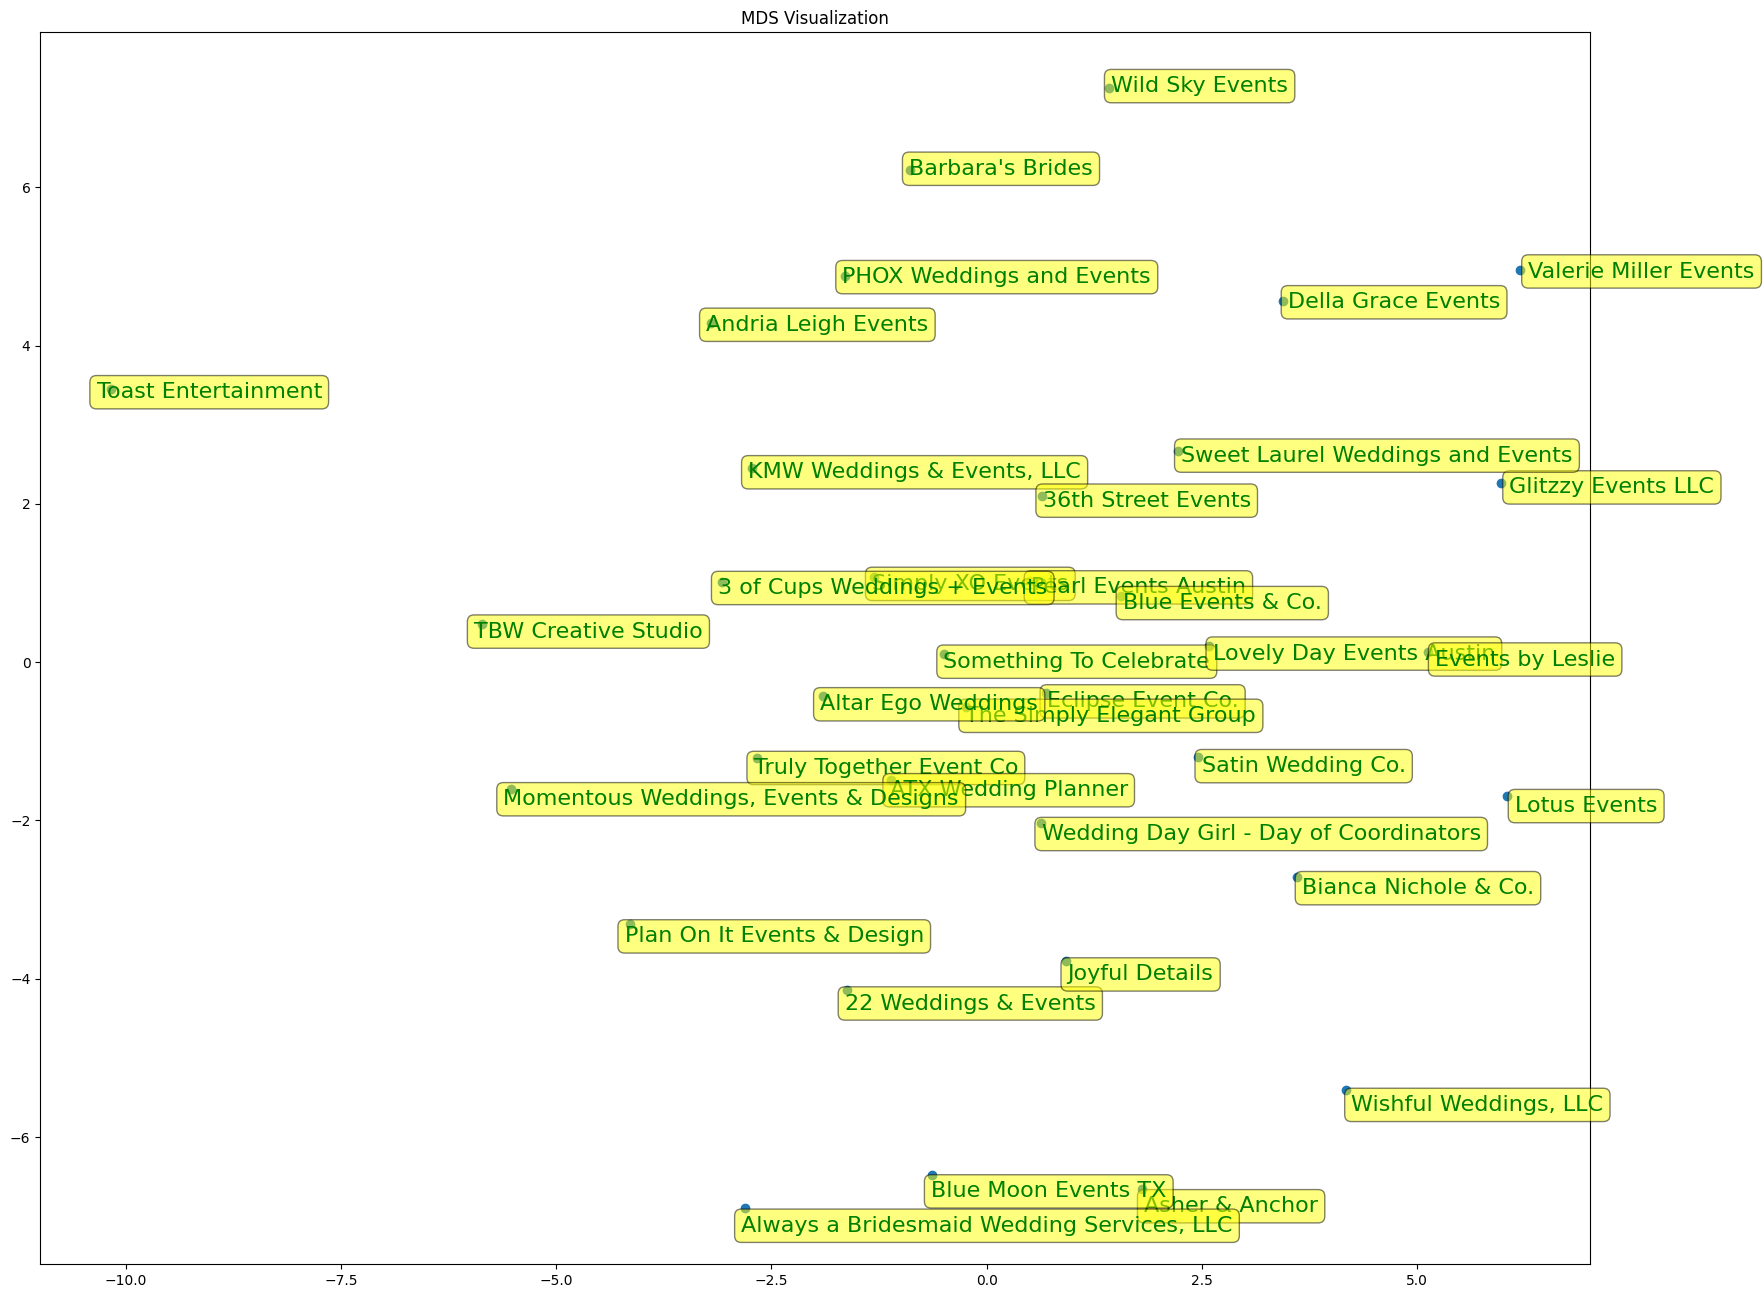

In [31]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

#Initialize the MDS model
distance_matrix = inverted_cosine_sim
mds = MDS(n_components=2, dissimilarity="precomputed")

#Fit the model to the distance matrix and transform the data to the lower-dimensional space
lower_dimensional_data = mds.fit_transform(distance_matrix)

plt.figure(figsize=(20, 16))
#Plot the lower-dimensional representation as a scatter plot
plt.scatter(lower_dimensional_data[:, 0], lower_dimensional_data[:, 1])

#Add labels for the data points (optional)
labels = df_reviews['Planners'].to_list()
for label, x, y in zip(labels, lower_dimensional_data[:, 0], lower_dimensional_data[:, 1]):
    plt.annotate(label, (x, y),
                 xytext=(x , y -10 ),  # The position of the text
                 textcoords='offset points',  # Interpret xytext as offset points
                 fontsize=16,
                 color='green',
                 bbox=dict(boxstyle='round', edgecolor='black', facecolor='yellow', alpha=0.5))

#Show the plot
plt.title('MDS Visualization')
plt.show()

In [32]:
import pandas as pd
import re
import nltk
import ast
nltk.download('stopwords')
from nltk.corpus import stopwords

df = pd.read_csv("image_label3.csv")
df['label'] = df['label'].fillna("[]")

# Get the list of English stop words
stop_words = set(stopwords.words('english'))

def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    # Tokenization and lowercase conversion
    tokens = nltk.word_tokenize(cleaned_text.lower())
    # Remove punctuation and stopwords
    cleaned_tokens = [token for token in tokens if token not in stop_words]
    # Rejoin tokens into a clean text string
    cleaned_text = " ".join(cleaned_tokens)
    
    return cleaned_text

def join_text(text):
    my_list = ast.literal_eval(text)
    concat_text = " ".join(my_list)
    return concat_text

profile_names = df['Planners'].unique()

planner_list = []
description = []

for planner in profile_names:
    filtered_df = df[df['Planners'] == planner]
    
    if len(filtered_df) < 20:
        continue
    planner_list.append(planner)
    word_count_dict = {}
    for idx in filtered_df.index:

        words =  join_text(df['label'][idx])
        words =  clean_text(words)
        words = words.split()
        for word in words:
            if word in word_count_dict.keys():
                word_count_dict[word] += 1
            else:
                word_count_dict[word] = 1

    item = list(word_count_dict.items())
    df_words = pd.DataFrame(item, columns =['Word', 'Count'])
    df_words = df_words.sort_values(by=['Count'],ascending=False)
    df_words.reset_index(inplace = True, drop = True)
    word_list = list(df_words.head(30)['Word'])

    word_list_frequency = []
    for word in word_list:
        count = df_words[df_words['Word'] == word]['Count'].to_list()[0]
        for i in range(count):
            word_list_frequency.append(word)

    # Concatenate the words into a single text
    concatenated_text = ' '.join(word_list_frequency)
    description.append(concatenated_text)

df_ig = pd.DataFrame({'Planners': planner_list, 'Description': description})

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Poonnawit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2>Find the wedding planners that received more than 20 reviews and have their own instagram accounts</h2>

In [33]:
print(len(df_ig))
print(len(df_reviews))

import pandas as pd
# Convert columns to sets
set1 = set(df_ig['Planners'])
set2 = set(df_reviews['Planners'])

# Find the intersection of the sets
intersection = set1.intersection(set2)

# Display the result
print("Intersection of  Planners :", intersection)
print("Intersection of :", set2-set1)
print(len(intersection))


55
36
Intersection of  Planners : {'The Simply Elegant Group', '3 of Cups Weddings + Events', "Barbara's Brides", 'Toast Entertainment', 'Always a Bridesmaid Wedding Services, LLC', 'Momentous Weddings, Events & Designs', '36th Street Events', 'Valerie Miller Events', 'PHOX Weddings and Events', 'Events by Leslie', 'Satin Wedding Co.', 'Pearl Events Austin', '22 Weddings & Events', 'Wedding Day Girl - Day of Coordinators', 'Wishful Weddings, LLC', 'Eclipse Event Co.', 'Lovely Day Events Austin', 'Joyful Details', 'Sweet Laurel Weddings and Events', 'Lotus Events', 'Something To Celebrate', 'TBW Creative Studio', 'Truly Together Event Co', 'Plan On It Events & Design', 'KMW Weddings & Events, LLC', 'ATX Wedding Planner', 'Della Grace Events', 'Bianca Nichole & Co.', 'Altar Ego Weddings', 'Andria Leigh Events', 'Simply XO Events', 'Glitzzy Events LLC', 'Wild Sky Events'}
Intersection of : {'Asher & Anchor', 'Blue Moon Events TX', 'Blue Events & Co.'}
33


<h2> Perform Cosine Similarity among Wedding Planners based on Image labels</h2>

In [34]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# documents
selected_rows = df_ig[df_ig['Planners'].isin(intersection)]
documents = selected_rows['Description'].to_list()

# Vectorize the documents using CountVectorizer
# vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

# Calculate cosine similarity
cosine_sim = cosine_similarity(X, X)

# The result is a similarity matrix
print("Cosine Similarity Matrix:")
print(cosine_sim.shape)
print(cosine_sim)


Cosine Similarity Matrix:
(33, 33)
[[1.         0.23063579 0.78140641 ... 0.69588    0.69701378 0.79105715]
 [0.23063579 1.         0.25423826 ... 0.31101432 0.24091278 0.2469077 ]
 [0.78140641 0.25423826 1.         ... 0.68626672 0.64838842 0.7547895 ]
 ...
 [0.69588    0.31101432 0.68626672 ... 1.         0.6190765  0.71200546]
 [0.69701378 0.24091278 0.64838842 ... 0.6190765  1.         0.68001374]
 [0.79105715 0.2469077  0.7547895  ... 0.71200546 0.68001374 1.        ]]


In [35]:
import numpy as np

# Assuming 'cosine_sim' is your cosine similarity matrix
# cosine_sim = cosine_similarity(X, X)

# Invert the values 
inverted_cosine_sim = 1/cosine_sim

# Set diagonal values to NaN
# np.fill_diagonal(inverted_cosine_sim, np.nan)

# Display the inverted cosine similarity matrix
print("Inverted Cosine Similarity Matrix:")
print(inverted_cosine_sim)

Inverted Cosine Similarity Matrix:
[[1.         4.33584055 1.27974378 ... 1.43702937 1.43469187 1.26413117]
 [4.33584055 1.         3.93331823 ... 3.21528606 4.15087988 4.05009652]
 [1.27974378 3.93331823 1.         ... 1.45715941 1.54228541 1.3248727 ]
 ...
 [1.43702937 3.21528606 1.45715941 ... 1.         1.61530927 1.40448361]
 [1.43469187 4.15087988 1.54228541 ... 1.61530927 1.         1.47055853]
 [1.26413117 4.05009652 1.3248727  ... 1.40448361 1.47055853 1.        ]]


c:\Users\Poonnawit\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


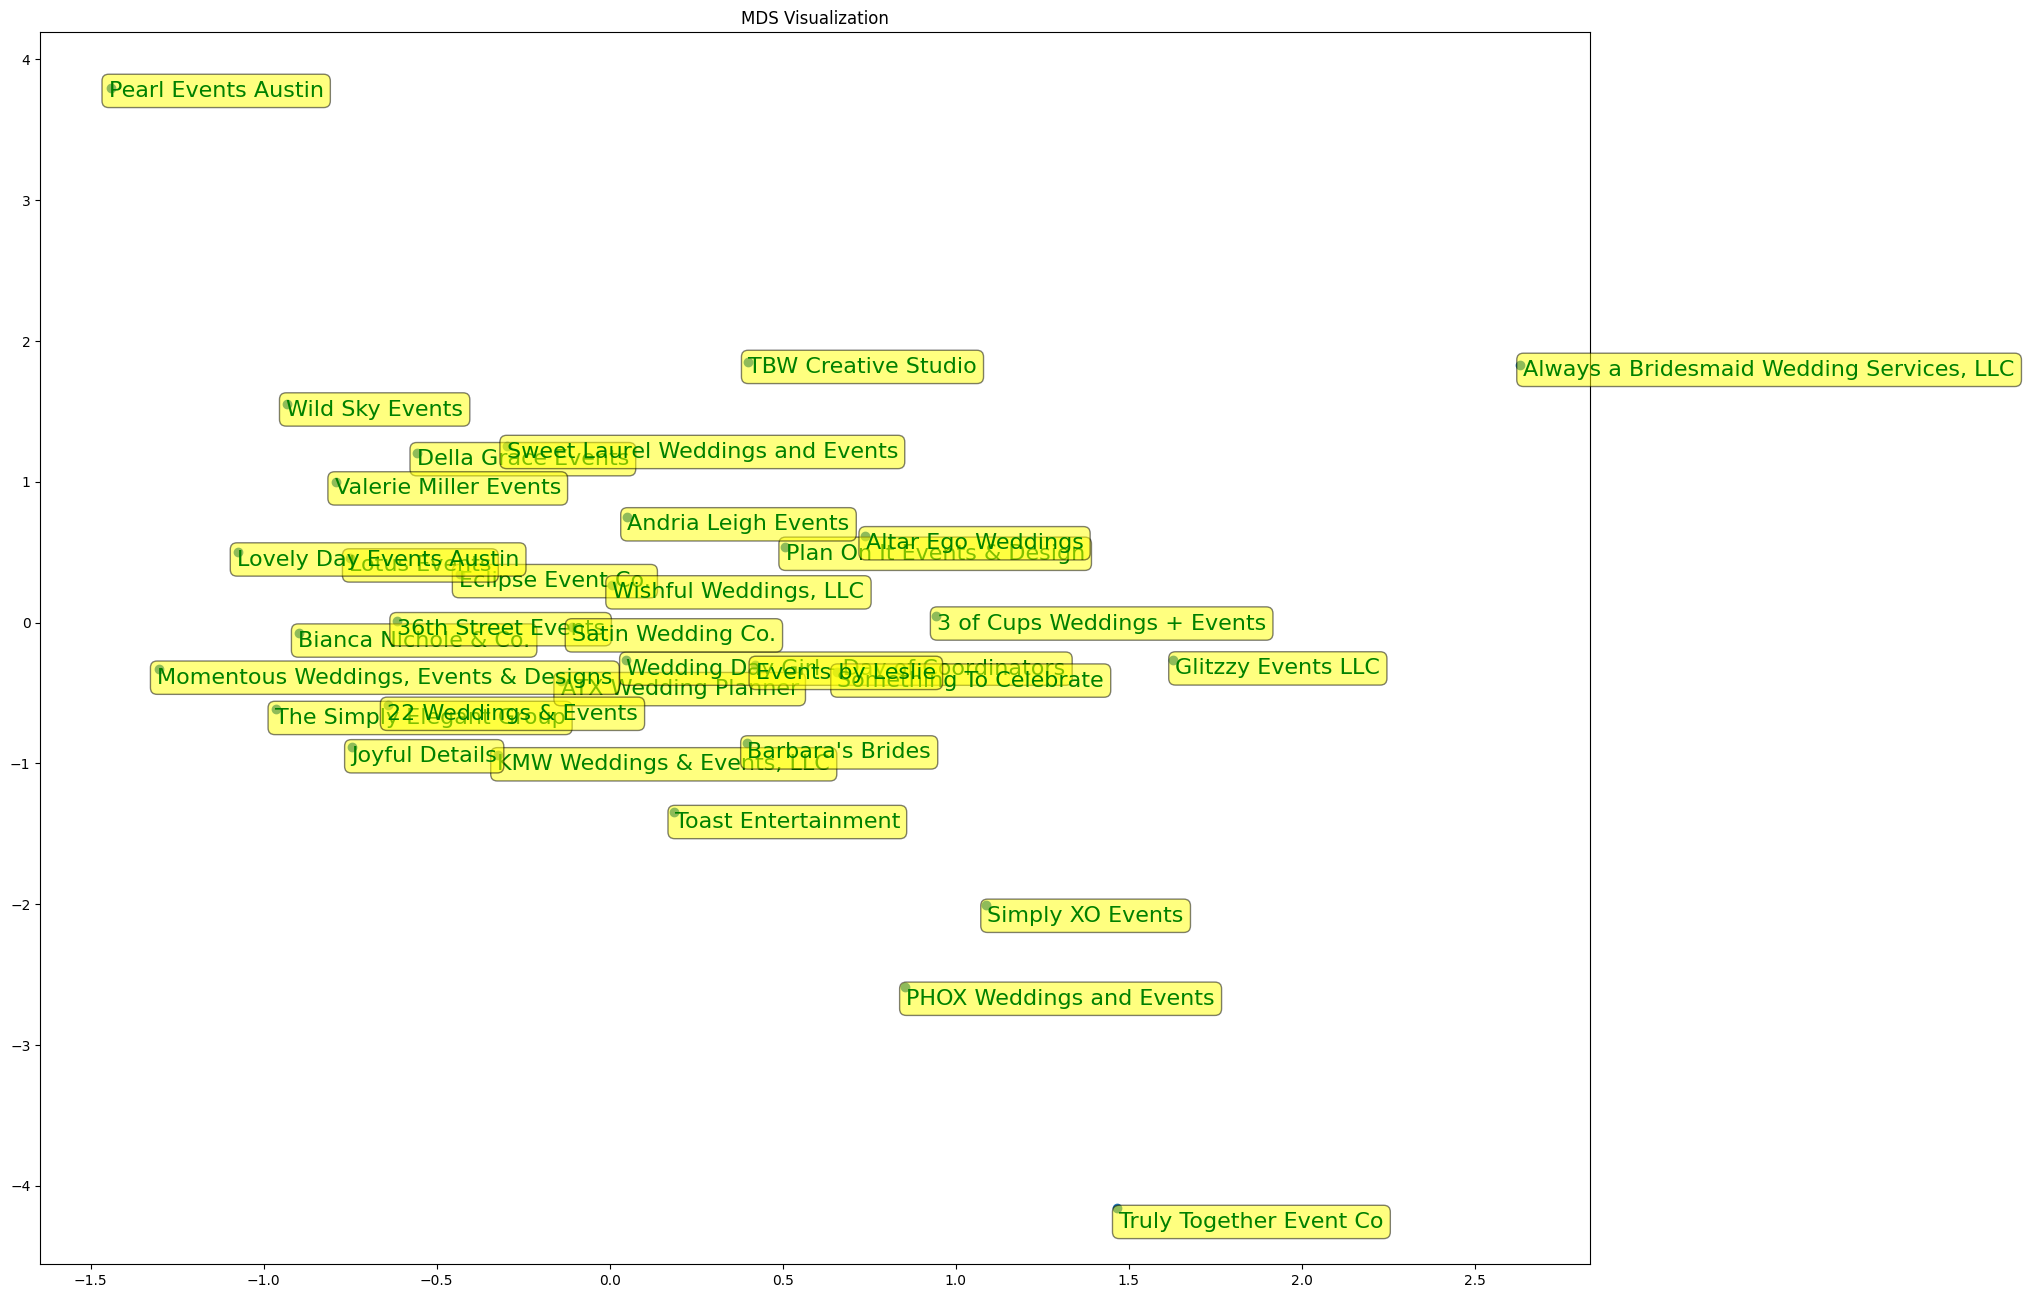

In [36]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt


#Initialize the MDS model
distance_matrix = inverted_cosine_sim
mds = MDS(n_components=2, dissimilarity="precomputed")


#Fit the model to the distance matrix and transform the data to the lower-dimensional space
lower_dimensional_data = mds.fit_transform(distance_matrix)

plt.figure(figsize=(20, 16))
#Plot the lower-dimensional representation as a scatter plot
plt.scatter(lower_dimensional_data[:, 0], lower_dimensional_data[:, 1])

#Add labels for the data points (optional)
labels = selected_rows['Planners'].to_list()
for label, x, y in zip(labels, lower_dimensional_data[:, 0], lower_dimensional_data[:, 1]):
    plt.annotate(label, (x, y),
                 xytext=(x , y -10 ),  # The position of the text
                 textcoords='offset points',  # Interpret xytext as offset points
                 fontsize=16,
                 color='green',
                 bbox=dict(boxstyle='round', edgecolor='black', facecolor='yellow', alpha=0.5))

#Show the plot
plt.title('MDS Visualization')
plt.show()

<h2>Find the lift ratio between wedding planners and attributes</h2>

In [39]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

df = pd.read_csv("wedding_planner_reviews_raw.csv")
df['Reviews'] = df['Reviews'].fillna("#")


planner_counts = df.groupby('Planner_Name').size().reset_index(name='reviewCount')
# Display the result
print(planner_counts)

# Get the list of English stop words
stop_words = set(stopwords.words('english'))

def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    # Tokenization and lowercase conversion
    #print(cleaned_text)
    tokens = nltk.word_tokenize(cleaned_text.lower())
    # Remove punctuation and stopwords
    cleaned_tokens = [token for token in tokens if token not in stop_words]
    # Rejoin tokens into a clean text string
    cleaned_text = " ".join(cleaned_tokens)
    
    return cleaned_text

word_count_dict = {}
feature_list = ["coordinator","planning","schedule","venue","stress"]
for idx in df.index:
    words =  clean_text(df['Reviews'][idx])
    words = words.split()
    for word in feature_list:
        if word in words:
            if word in word_count_dict.keys():
                word_count_dict[word] += 1
            else:
                word_count_dict[word] = 1

print(len(word_count_dict.keys()))

item = list(word_count_dict.items())
df_words = pd.DataFrame(item, columns =['Word', 'Count'])
df_words = df_words.sort_values(by=['Count'],ascending=False)
df_words.reset_index(inplace = True, drop = True)
print(df_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Poonnawit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                              Planner_Name  reviewCount
0                     22 Weddings & Events           20
1              3 of Cups Weddings + Events           63
2                       36th Street Events          183
3                       A Brideâ€™s Bestie            4
4                      ATX Wedding Planner           67
..                                     ...          ...
56              Vickyâ€™s Visionary Events            9
57                             Wed in Fred           11
58  Wedding Day Girl - Day of Coordinators           55
59                         Wild Sky Events           39
60                   Wishful Weddings, LLC           44

[61 rows x 2 columns]
5
          Word  Count
0     planning   1967
1  coordinator    920
2       stress    680
3        venue    645
4     schedule    272


In [41]:

planners_to_filter = ["Blue Moon Events TX","Always a Bridesmaid Wedding Services, LLC","3 of Cups Weddings + Events","Asher & Anchor","Something To Celebrate"] 
filtered_df = df[df['Planner_Name'].isin(planners_to_filter)].reset_index()
#print(filtered_df)


planner_counts_filtered = planner_counts[planner_counts['Planner_Name'].isin(planners_to_filter)].reset_index()
print(planner_counts_filtered)
#filtered_df.to_csv("filter_df.csv")

   index                               Planner_Name  reviewCount
0      1                3 of Cups Weddings + Events           63
1      6  Always a Bridesmaid Wedding Services, LLC           23
2      8                             Asher & Anchor           45
3     13                        Blue Moon Events TX          116
4     47                     Something To Celebrate          281


In [42]:
def lift_ratio_3(x, y, df, df_top_brand, df_top_feature):

    word_counter = 0
    df_clean = df[df['Planner_Name'] == df_top_brand['Planner_Name'][x]]
    for idx in df_clean.index:
        words = clean_text(df_clean['Reviews'][idx]).split()
        for i in range(len(words)):
            if df_top_feature['Word'][y] in words:
                word_counter += 1
                break

    count_top_brand = df_top_brand['reviewCount'][x]
    count_top_feature = df_top_feature['Count'][y]
    n_sample = len(df_clean.index)
    lift = (word_counter*n_sample)/(count_top_brand*count_top_feature)
    return lift

In [45]:
df_top_brand = planner_counts_filtered  
print(df_top_brand)
df_top_feature = df_words
print(df_top_feature)

import numpy as np
mtx_t = [[float(0) for i in range(len(df_top_feature.index))] for i in range(len(df_top_brand.index))]
mtx_t = np.array(mtx_t)


for x in df_top_brand.index:
    for y in df_top_feature.index:
            #print(df_top_brand['Planner_Name'][x],df_top_feature['Word'][y])
            lift = lift_ratio_3(x,y,filtered_df,df_top_brand,df_top_feature)
            mtx_t[x,y] = lift
            #print(lift)
            
print(mtx_t)

   index                               Planner_Name  reviewCount
0      1                3 of Cups Weddings + Events           63
1      6  Always a Bridesmaid Wedding Services, LLC           23
2      8                             Asher & Anchor           45
3     13                        Blue Moon Events TX          116
4     47                     Something To Celebrate          281
          Word  Count
0     planning   1967
1  coordinator    920
2       stress    680
3        venue    645
4     schedule    272
[[0.0218607  0.025      0.01176471 0.02790698 0.01470588]
 [0.00254194 0.00978261 0.01029412 0.00775194 0.00367647]
 [0.01067616 0.02282609 0.00882353 0.01705426 0.01102941]
 [0.01982715 0.05434783 0.01617647 0.02015504 0.06985294]
 [0.06456533 0.09456522 0.07647059 0.04496124 0.04779412]]


In [46]:
df_brand_attribute = pd.DataFrame(mtx_t, columns = df_top_feature['Word'], index = df_top_brand['Planner_Name'])
print(df_brand_attribute)

Word                                       planning  coordinator    stress  \
Planner_Name                                                                 
3 of Cups Weddings + Events                0.021861     0.025000  0.011765   
Always a Bridesmaid Wedding Services, LLC  0.002542     0.009783  0.010294   
Asher & Anchor                             0.010676     0.022826  0.008824   
Blue Moon Events TX                        0.019827     0.054348  0.016176   
Something To Celebrate                     0.064565     0.094565  0.076471   

Word                                          venue  schedule  
Planner_Name                                                   
3 of Cups Weddings + Events                0.027907  0.014706  
Always a Bridesmaid Wedding Services, LLC  0.007752  0.003676  
Asher & Anchor                             0.017054  0.011029  
Blue Moon Events TX                        0.020155  0.069853  
Something To Celebrate                     0.044961  0.047794  


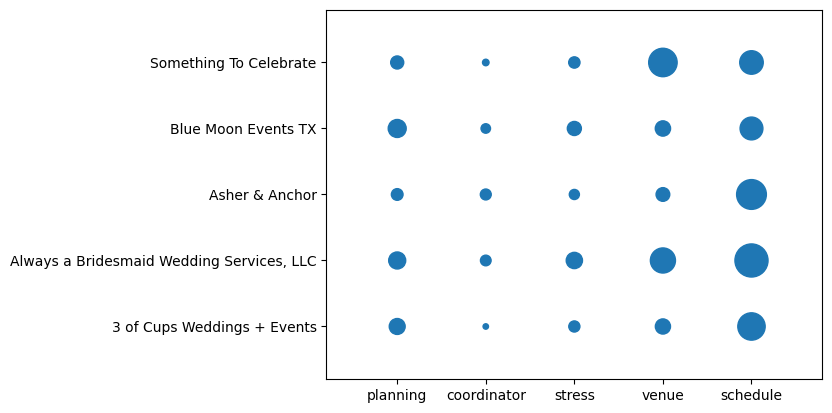

In [47]:
import numpy as np
import matplotlib.pyplot as plt

y,x = np.meshgrid(df_brand_attribute.index, df_brand_attribute.columns)

df_brand_attribute_scale = 6000*df_brand_attribute

plt.scatter(x=x.flatten(), y=y.flatten(), s=df_brand_attribute_scale.values.flatten())
plt.margins(0.2)
plt.show()
